In [1]:
##--------------------------------------------------------------------------------
## Summary : Implement a variation of Deep Dream algorithm
## Author  : Venkata Srinivas Vemprala
## SourceCode : https://github.com/vesrinivas/DeepLearning
##--------------------------------------------------------------------------------

## Nice tutorial on Deep Dream : http://www3.cs.stonybrook.edu/~cse352/G15Dream.pdf

## kindly note that all images are taken from google

%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import Inception5h
import os
import download
import PIL.Image
from IPython.display import Image, display

import PIL.Image
from scipy.ndimage.filters import gaussian_filter

In [2]:
model = Inception5h.Inception5h()

In [3]:
# Helper function to load images
def loadImage(path):
    image = PIL.Image.open(path)
    return np.float32(image)

# Helper function to save image
def saveImage(image, path):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)
    
    # Convert to bytes.
    image = image.astype(np.uint8)
    
    # Write the image-file in jpeg-format.
    with open(path, 'wb') as file:
        PIL.Image.fromarray(image).save(file, 'jpeg')

# plot images
def plotImage(image):
    image = np.clip(image/255.0, 0.0, 1.0)
        
    # Plot using matplotlib.
    plt.imshow(image, interpolation='spline16')
    plt.show()

In [4]:
# helper function to normalize image(using min-max normalization)
def normalize_image(x):
    xMin = np.min(image)
    xMax = np.max(image)
    
    xNorm = (x-xMin)/(xMax-xMin)

# helper function to resize image
def resizeImage(image, size=None, factor=None):
    # If a rescaling-factor is provided then use it.
    if factor is not None:
        # Scale the numpy array's shape for height and width.
        size = np.array(image.shape[0:2]) * factor
        
        # change the size to int
        size = size.astype(int)
    else:
        # Ensure the size has length 2.
        size = size[0:2]
    
    # The height and width is reversed in numpy vs. PIL.
    size = tuple(reversed(size))
 
    # Ensure the pixel-values are between 0 and 255.
    img = np.clip(a=image, a_min=0.0, a_max=255.0)
    
    # Convert the pixels to 8-bit bytes.
    img = img.astype(np.uint8)
    
    # Create PIL-object from numpy array.
    img = PIL.Image.fromarray(img)
    
    # Resize the image.
    img_resized = img.resize(size, PIL.Image.LANCZOS)
    
    # Convert 8-bit pixel values back to floating-point.
    img_resized = np.float32(img_resized)

    return img_resized

In [5]:
# print various layer names
print(model.layer_names)

['conv2d0', 'conv2d1', 'conv2d2', 'mixed3a', 'mixed3b', 'mixed4a', 'mixed4b', 'mixed4c', 'mixed4d', 'mixed4e', 'mixed5a', 'mixed5b']


In [6]:
# helper function to plot the gradients
def plotGradient(gradient):
    # Normalize the gradient
    normalizedGradient = normalize_image(gradient)
    
    # plot the image
    plt.imshow(normalizedGradient,interpolation='spline16')
    

In [7]:
def genDeepDream(image,layerName,numIterations=10,stepSize = 3.0):
    # show the image
    ## plotImage(image=image)
    
    # Get the gradient at the given layer
    gradient = model.get_gradient(layerName)
    
    # start looping and plot gradient after each iteration
    for i in range(numIterations):
        
        # create a feed dictionary for the model
        feed_dict = model.create_feed_dict(image=image)
        
        # get the gradient
        g = session.run(gradient, feed_dict=feed_dict)
        # blur the gradients by different amounts to give a smooth 
        # texture to the image. At each iteration choose sigma as
        # i*4/numIterations +0.5
        
        sigma =  i*4.0/numIterations +0.5;
        gradSmoothHalf = gaussian_filter(g,sigma=(sigma*0.5))
        gradSmoothOne = gaussian_filter(g,sigma=sigma)
        gradSmoothtwo = gaussian_filter(g,sigma=(sigma*2))
        
        grad = gradSmoothHalf + gradSmoothOne + gradSmoothtwo
        grad = np.squeeze(grad)
        
        # compute the step size 
        # ensure that atleast 30% pixels are changed by stepSize
        stepSizeScaled =  stepSize/(np.std(grad) + 1e-8)
        
        # update image
        image = image+stepSizeScaled*grad

    return image
    

In [8]:
# Create a tensorflow session
session = tf.InteractiveSession(graph=model.graph)

In [9]:
# write a function to do recursive optimization of deep dream
def genDeepDreamWithOctave(image,layerName,numIterations=10,numOfOctaves=5,rescaleFactor=0.75,blend = 0.2,stepSize=3.0):
    
    # Check if numOfOctaves is greater than zero if not return image
    if(numOfOctaves>0):
        
        # blur the image and downscale it
        # blur must be done on x-y axis not across channels
        imageBlur = gaussian_filter(image,sigma=(0.5,0.5,0))
        
        # downscale image basing on rescale factor
        imageDownScaled = resizeImage(image=imageBlur,factor=rescaleFactor)
        
        # recursively call the fun to to get final downscaled image
        imageResult = genDeepDreamWithOctave(image=imageDownScaled,layerName=layerName,
                                             numIterations=numIterations,numOfOctaves=(numOfOctaves-1),
                                             rescaleFactor=rescaleFactor,blend=blend,stepSize=stepSize)
        
        # lets rescale the resultant image to its original size
        imageUpscaled = resizeImage(image=imageResult,size=image.shape)
        
        # blend the result image and upscaled image
        image = (1.0-blend)*imageUpscaled + blend*image
        
    # run the dream generation for this image
    imageResult = genDeepDream(image=image,layerName=layerName,
                                   numIterations=numIterations,stepSize=stepSize)
        
    #print the progress
    print("After Octave level : ",numOfOctaves)
    plotImage(imageResult)
    return imageResult

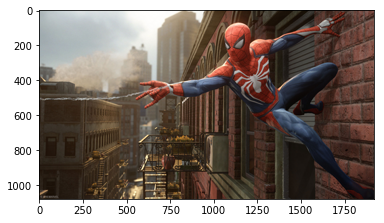

(1080, 1920, 3)


In [22]:
image = loadImage(path='inception/spidy.jpg')
plotImage(image)
print(image.shape)

Tensor("conv2d2:0", shape=(?, ?, ?, 192), dtype=float32, device=/device:CPU:0)
After Octave level :  0


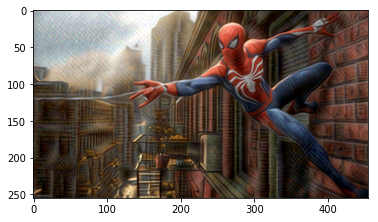

After Octave level :  1


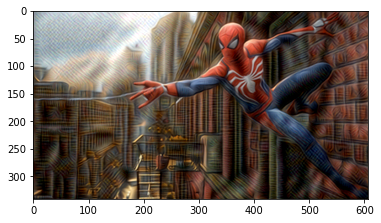

After Octave level :  2


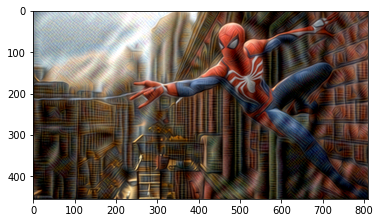

After Octave level :  3


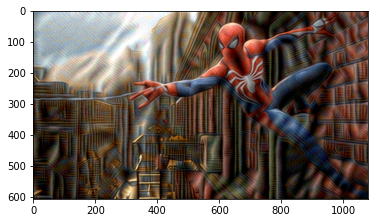

After Octave level :  4


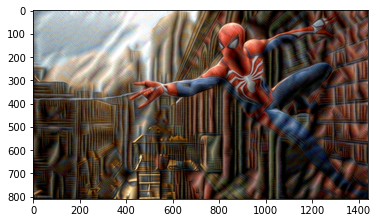

After Octave level :  5


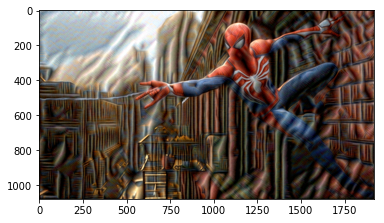

In [11]:
layer_tensor = model.layer_tensors[2]
print(layer_tensor)
finalImage = genDeepDreamWithOctave(layerName=layer_tensor,image=image,stepSize=3.0)
saveImage(finalImage,path='inception/layer2DreamSpidy.jpg')

Tensor("mixed3a:0", shape=(?, ?, ?, 256), dtype=float32, device=/device:CPU:0)
After Octave level :  0


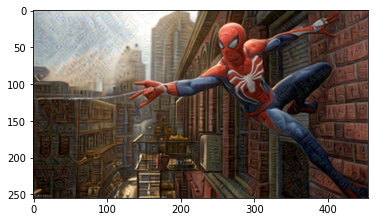

After Octave level :  1


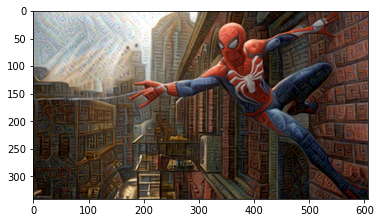

After Octave level :  2


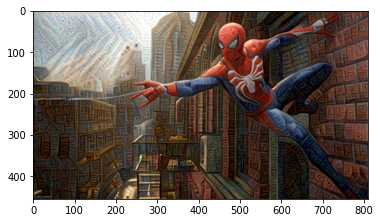

After Octave level :  3


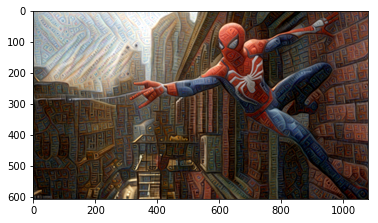

After Octave level :  4


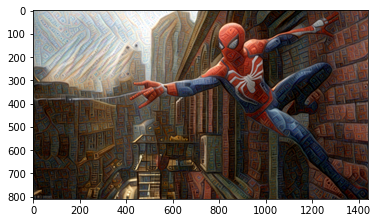

After Octave level :  5


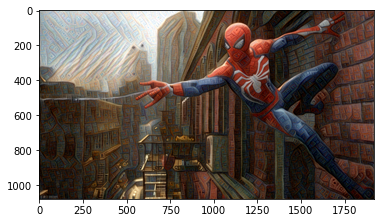

In [12]:
layer_tensor = model.layer_tensors[3]
print(layer_tensor)
finalImage = genDeepDreamWithOctave(layerName=layer_tensor,image=image,stepSize=3.0)
saveImage(finalImage,path='inception/layer3DreamSpidy.jpg')

Tensor("mixed4b:0", shape=(?, ?, ?, 512), dtype=float32, device=/device:CPU:0)
After Octave level :  0


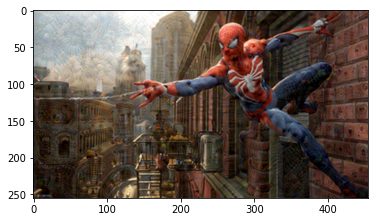

After Octave level :  1


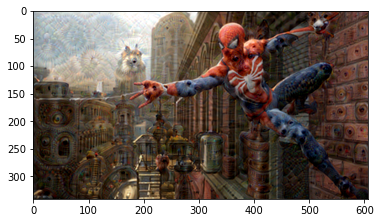

After Octave level :  2


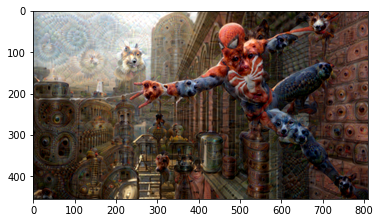

After Octave level :  3


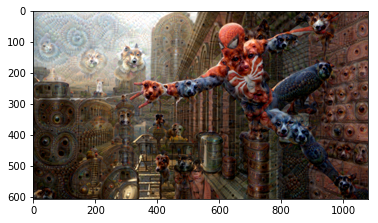

After Octave level :  4


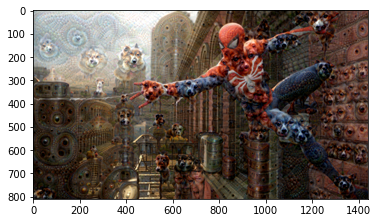

After Octave level :  5


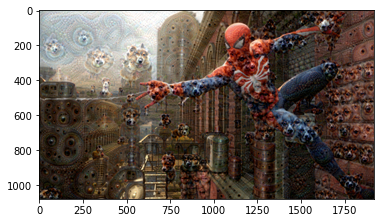

In [13]:
layer_tensor = model.layer_tensors[6]
print(layer_tensor)
finalImage = genDeepDreamWithOctave(layerName=layer_tensor,image=image,stepSize=3.0)
saveImage(finalImage,path='inception/layer6DreamSpidy.jpg')

Tensor("mixed4d:0", shape=(?, ?, ?, 528), dtype=float32, device=/device:CPU:0)
After Octave level :  0


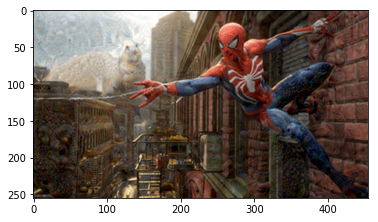

After Octave level :  1


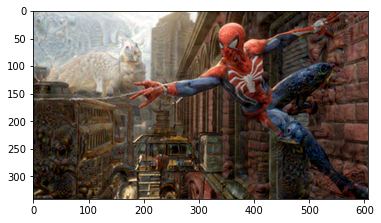

After Octave level :  2


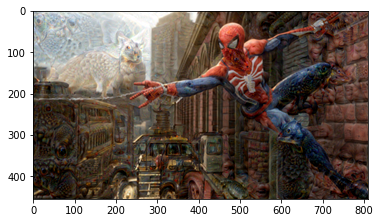

After Octave level :  3


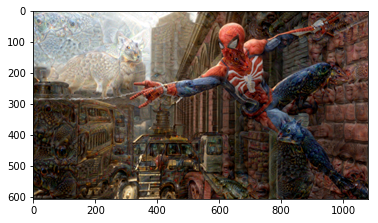

After Octave level :  4


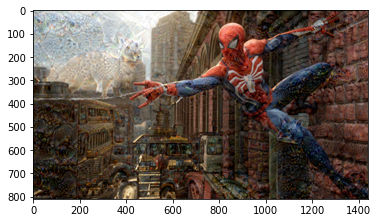

After Octave level :  5


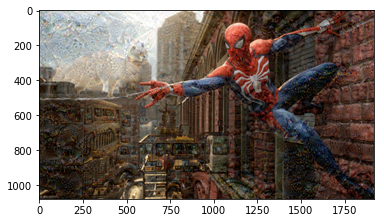

In [23]:
layer_tensor = model.layer_tensors[8]
print(layer_tensor)
finalImage = genDeepDreamWithOctave(layerName=layer_tensor,image=image,stepSize=3.0)
saveImage(finalImage,path='inception/layer8DreamSpidy.jpg')

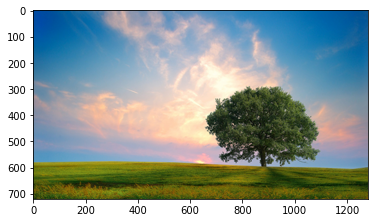

In [24]:
image = loadImage(path='inception/nature.jpg')
plotImage(image)

Tensor("mixed4d:0", shape=(?, ?, ?, 528), dtype=float32, device=/device:CPU:0)
After Octave level :  0


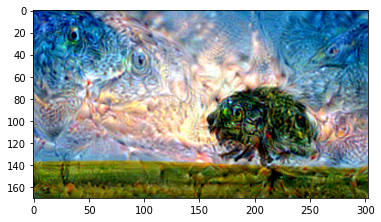

After Octave level :  1


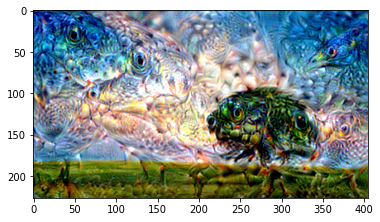

After Octave level :  2


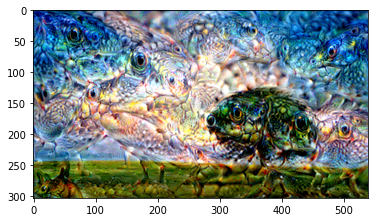

After Octave level :  3


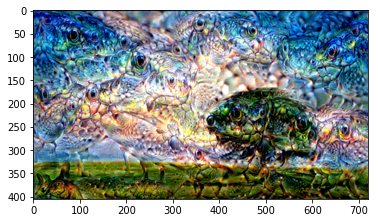

After Octave level :  4


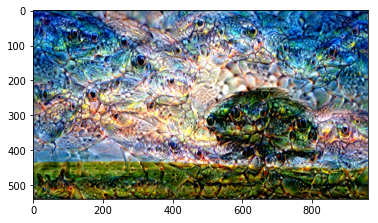

After Octave level :  5


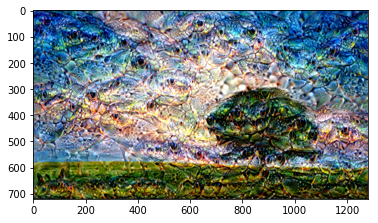

In [25]:
layer_tensor = model.layer_tensors[8]
print(layer_tensor)
finalImage = genDeepDreamWithOctave(layerName=layer_tensor,image=image,numIterations=50,stepSize=5.0)
saveImage(finalImage,path='inception/layer8DreamNature.jpg')

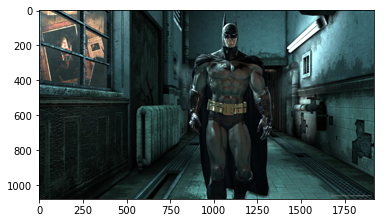

In [26]:
image = loadImage(path='inception/batman-as-a-videogame-character.jpg')
plotImage(image)

Tensor("mixed4d:0", shape=(?, ?, ?, 528), dtype=float32, device=/device:CPU:0)
After Octave level :  0


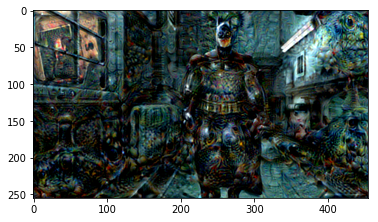

After Octave level :  1


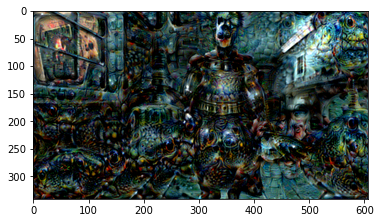

After Octave level :  2


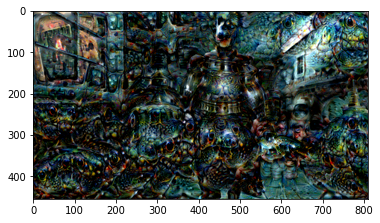

After Octave level :  3


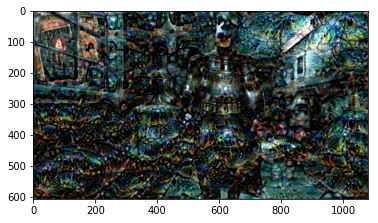

After Octave level :  4


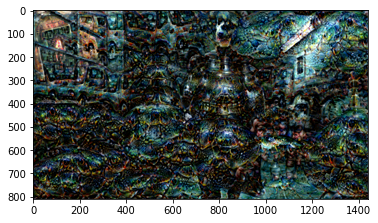

After Octave level :  5


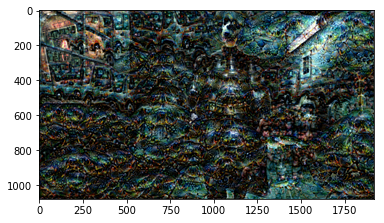

In [27]:
layer_tensor = model.layer_tensors[8]
print(layer_tensor)
finalImage = genDeepDreamWithOctave(layerName=layer_tensor,image=image,numIterations=50,stepSize=5.0)
saveImage(finalImage,path='inception/layer8DreamBatman.jpg')